In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
torch.manual_seed(1)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2021-ai-w4-p1/submit.csv
/kaggle/input/2021-ai-w4-p1/train.csv
/kaggle/input/2021-ai-w4-p1/test.csv


In [2]:
X = pd.read_csv('/kaggle/input/2021-ai-w4-p1/train.csv')
y = X['Diabetes']
X = X.drop(['Diabetes','Pregnancies', 'SkinThickness'], axis = 1)
test = pd.read_csv('/kaggle/input/2021-ai-w4-p1/test.csv').drop(['Pregnancies', 'SkinThickness'], axis=1)

In [3]:
#'Glucose','BloodPressure','SkinThickness','BMI',Pregnancies','Insulin','Age','DiabetesPedigreeFunction'
# sns.heatmap(X.corr())

In [4]:
X.describe()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,120.849162,69.685289,79.836127,31.975605,0.469920,33.074488
std,32.339523,18.094374,115.196730,7.624495,0.342087,11.685319
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,99.000000,64.000000,0.000000,26.800000,0.241000,24.000000
50%,117.000000,72.000000,36.000000,32.000000,0.374000,29.000000
75%,139.000000,80.000000,129.000000,36.500000,0.612000,41.000000
max,199.000000,122.000000,846.000000,67.100000,2.420000,81.000000


In [5]:
X['Insulin'][X[X['Insulin'] == 0].index] = X['Insulin'].mean()
# X['SkinThickness'][X[X['SkinThickness'] == 0].index] = X['SkinThickness'].mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
X.describe()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,120.849162,69.685289,118.639160,31.975605,0.469920,33.074488
std,32.339523,18.094374,93.049119,7.624495,0.342087,11.685319
min,0.000000,0.000000,14.000000,0.000000,0.078000,21.000000
25%,99.000000,64.000000,79.836127,26.800000,0.241000,24.000000
50%,117.000000,72.000000,79.836127,32.000000,0.374000,29.000000
75%,139.000000,80.000000,129.000000,36.500000,0.612000,41.000000
max,199.000000,122.000000,846.000000,67.100000,2.420000,81.000000


array([[<AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>]], dtype=object)

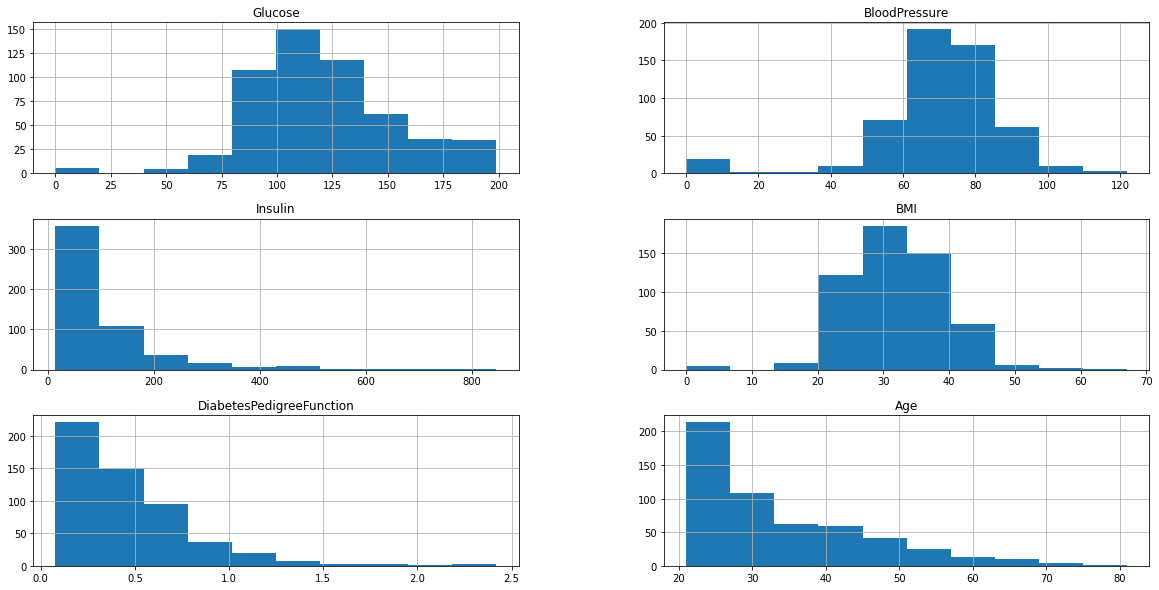

In [7]:
X[['Glucose','BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].hist(figsize=(20, 10))


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)
test_sc = sc.transform(test)

X_sc = torch.FloatTensor(X_sc)
test_sc = torch.FloatTensor(test_sc)

In [9]:
# X['Insulin'] = sc.fit_transform(X['Insulin'].to_numpy().reshape(-1, 1))
# test['Insulin'] = sc.fit_transform(test['Insulin'].to_numpy().reshape(-1, 1))
# X['DiabetesPedigreeFunction'] = sc.fit_transform(X['DiabetesPedigreeFunction'].to_numpy().reshape(-1, 1))
# test['DiabetesPedigreeFunction'] = sc.fit_transform(test['DiabetesPedigreeFunction'].to_numpy().reshape(-1, 1))
# X['Age'] = sc.fit_transform(X['Age'].to_numpy().reshape(-1, 1))
# test['Age'] = sc.fit_transform(test['Age'].to_numpy().reshape(-1, 1))
# X['Pregnancies'] = sc.fit_transform(X['Pregnancies'].to_numpy().reshape(-1, 1))
# test['Pregnancies'] = sc.fit_transform(test['Pregnancies'].to_numpy().reshape(-1, 1))

In [10]:
X = torch.FloatTensor(X.to_numpy())
test = torch.FloatTensor(test.to_numpy())
y = torch.FloatTensor(y.to_numpy())

In [11]:
W = torch.zeros((6, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([W, b], lr = 1e-2)
nb_epochs = 20000
for epoch in range(nb_epochs + 1):
    hypothesis = torch.sigmoid(X_sc.matmul(W) + b)
    
    loss = torch.nn.BCELoss()
    cost = loss(hypothesis, y.unsqueeze(1))
    # cost = -(y*torch.log(hypothesis)+(1-y)*torch.log(1-hypothesis)).mean()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 5000 == 0:
        print('Epoch {:4d}/{}   W:{:.6f}   b:{:.6f}   Cost : {:.6f}'.format(
            epoch, nb_epochs, W[0].item(), b.item(), cost.item()
        ))

Epoch    0/20000   W:0.002283   b:-0.001499   Cost : 0.693147
Epoch 5000/20000   W:1.114555   b:-0.871410   Cost : 0.462408
Epoch 10000/20000   W:1.135442   b:-0.881154   Cost : 0.462370
Epoch 15000/20000   W:1.136192   b:-0.881481   Cost : 0.462370
Epoch 20000/20000   W:1.136192   b:-0.881481   Cost : 0.462370


In [12]:
# X_test = torch.FloatTensor(X_test.to_numpy())
# y_test = torch.FloatTensor(y_test.to_numpy())

0.45 77.65%
0.451 77.65%
0.452 77.65%
0.453 77.65%
0.454 77.84%
0.455 77.84%
0.456 77.65%
0.457 77.65%
0.458 77.65%
0.459 77.65%
0.46 77.65%
0.461 77.65%
0.462 77.65%
0.463 77.65%
0.464 77.65%
0.465 77.84%
0.466 77.65%
0.467 77.47%
0.468 77.65%
0.46900000000000003 77.65%
0.47000000000000003 77.65%
0.47100000000000003 77.84%
0.47200000000000003 77.84%
0.47300000000000003 78.03%
0.47400000000000003 78.03%
0.47500000000000003 78.03%
0.47600000000000003 78.03%
0.47700000000000004 78.21%
0.47800000000000004 78.21%
0.47900000000000004 78.21%
0.48 78.21%
0.481 78.21%
0.482 78.21%
0.483 78.03%
0.484 78.03%
0.485 78.21%
0.486 78.21%
0.487 78.21%
0.488 78.21%
0.489 78.21%
0.49 78.21%
0.491 78.21%
0.492 78.21%
0.493 78.21%
0.494 78.21%
0.495 78.03%
0.496 78.03%
0.497 78.03%
0.498 78.40%
0.499 78.40%
0.5 78.40%
0.501 78.40%
0.502 78.40%
0.503 78.58%
0.504 78.58%
0.505 78.58%
0.506 78.58%
0.507 78.58%
0.508 78.58%
0.509 78.58%
0.51 78.77%
0.511 78.77%
0.512 78.77%
0.513 78.77%
0.514 78.77%
0.515 78

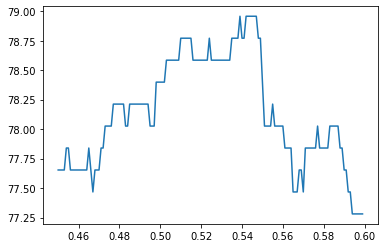

In [13]:
hypothesis = torch.sigmoid(X_sc.matmul(W) + b)
# print(hypothesis[:10])

list1 = []
list2 = []
for i in range(450, 600):

    prediction = hypothesis >= torch.FloatTensor([i*0.001])
    #print(prediction[prediction == True].sum())

    correct_prediction = prediction.squeeze().float() == y
    # print(correct_prediction.shape)

    accuracy = correct_prediction.sum().item() / len(correct_prediction)
    print('{} {:2.2f}%'.format(i*0.001, accuracy*100))
    list1.append(i*0.001)
    list2.append(accuracy*100)
    
plt.plot(list1, list2)
# print(list2[:10])

In [14]:
hypothesis = torch.sigmoid(X_sc.matmul(W) + b)
# print(hypothesis[:20])
prediction = hypothesis >= torch.FloatTensor([0.54])
print(prediction[prediction == True].sum())
correct_prediction = prediction.squeeze().float() == y

accuracy = correct_prediction.sum().item() / len(correct_prediction)
print('{} {:2.2f}%'.format(i*0.001, accuracy*100))

tensor(144)
0.599 78.77%


In [15]:
submit = pd.read_csv('/kaggle/input/2021-ai-w4-p1/submit.csv')
submit.head()


,ID,Diabetes
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [16]:
hypothesis = torch.sigmoid(test_sc.matmul(W) + b)
prediction = hypothesis >= torch.FloatTensor([0.54])

sum = 0
for a in range(len(prediction)):
    if prediction[a]==1:
        sum = sum + 1
        
print(sum)

submit['Diabetes'] = prediction.squeeze().int()

72


In [17]:
submit

,ID,Diabetes
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
226,226,0
227,227,0
228,228,0
229,229,0


In [18]:
submit.to_csv('submit.csv', index=False)